In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

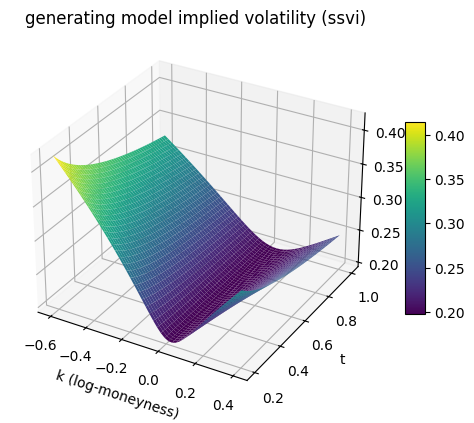

In [ ]:
def ssvi_implied_vol(k, t, eta=1.6, lam=0.4, rho=-0.15):
    k = np.asarray(k, dtype=float)
    t = np.asarray(t, dtype=float)

    tiny = 1e-14
    t_safe = np.maximum(t, tiny)

    theta = 0.04 * t_safe
    phi = eta * (theta**(-lam))
    tmp = (phi * k) + rho
    w = (theta / 2.0) * (
        1.0
        + rho * phi * k
        + np.sqrt(tmp**2 + (1.0 - rho**2))
    )

    w = np.maximum(w, tiny)
    implied_vol = np.sqrt(w / t_safe)
    return implied_vol

def plot_ssvi_surface():
    k_values = np.linspace(-0.6, 0.4, 50)
    t_values = np.linspace(0.2, 1.0, 50)
    kk, tt = np.meshgrid(k_values, t_values)
    vol_surf = ssvi_implied_vol(kk, tt)

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        kk, tt, vol_surf,
        rstride=1, cstride=1, cmap=cm.viridis, edgecolor='none'
    )
    ax.set_xlabel('k (log-moneyness)')
    ax.set_ylabel('t')
    ax.set_zlabel(r'$\sigma_{BS}$')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.title('generating model implied volatility (ssvi)')
    plt.show()

def build_reference_measure(x_grid, n_times, mu_ref=0.0, sigma_ref=0.2, dt=0.01):
    kernel = np.zeros((n_times, len(x_grid), len(x_grid)))
    var = sigma_ref**2 * dt
    denom = np.sqrt(2.0 * np.pi * var)

    for k in range(n_times):
        for i, x0 in enumerate(x_grid):
            mean = x0 + mu_ref*dt
            diff = x_grid - mean
            pdf_vals = np.exp(-0.5*(diff**2)/var) / denom
            pdf_vals /= (np.sum(pdf_vals) + 1e-16)  
            kernel[k, i, :] = pdf_vals
    return kernel


class SinkhornSolver:
    def __init__(self, x_grid, kernel, lam_mart=1e4, lam_prices=1e4):
        self.x_grid = x_grid
        self.kernel = kernel
        self.n_times = kernel.shape[0]
        self.n_x = len(x_grid)

        self.phi_nu = np.zeros((self.n_times+1, self.n_x))   
        self.phi_m  = np.zeros((self.n_times,   self.n_x))   
        self.Lambda = np.zeros((self.n_times+1,))            

        self.lam_mart  = lam_mart
        self.lam_prices= lam_prices

        self.psi_up   = np.zeros((self.n_times+1, self.n_x))
        self.psi_down = np.zeros((self.n_times+1, self.n_x))

    def update_psi_down(self):
        for k in reversed(range(self.n_times)):
            tmp = np.zeros(self.n_x)
            for ix in range(self.n_x):
                vals = []
                for jx in range(self.n_x):
                    exponent = (
                        self.psi_down[k+1, jx]
                        + self.phi_nu[k+1, jx]
                        + self.phi_m[k, ix]
                    )
                    vals.append(np.exp(exponent) * self.kernel[k, ix, jx])
                tmp[ix] = np.log(np.sum(vals) + 1e-16)
            self.psi_down[k] = tmp

    def update_psi_up(self):
        for k in range(self.n_times):
            tmp = np.zeros(self.n_x)
            for jx in range(self.n_x):
                vals = []
                for ix in range(self.n_x):
                    exponent = (
                        self.psi_up[k, ix]
                        + self.phi_nu[k, ix]
                        + self.phi_m[k, ix]
                    )
                    vals.append(np.exp(exponent) * self.kernel[k, ix, jx])
                tmp[jx] = np.log(np.sum(vals) + 1e-16)
            self.psi_up[k+1] = tmp

    def solve_marginal(self, k):
        grad = - (self.phi_nu[k])  
        self.phi_nu[k] += 0.01 * grad

    def solve_prices(self, k):
        self.Lambda[k] += 0.02  

    def solve_drift_vol(self, k):
        grad = - (self.phi_m[k]) + self.lam_mart * 0.0  
        self.phi_m[k] += 0.01 * grad

    def run_sinkhorn(self, max_iter=100, tol=1e-6):
        for it in range(max_iter):
            self.update_psi_down()

            for k in range(self.n_times):
                self.solve_marginal(k)
                self.solve_prices(k)
                self.solve_drift_vol(k)
                
                self.update_psi_up()

            self.solve_marginal(self.n_times)
            self.solve_prices(self.n_times)

            err = np.max(np.abs(self.psi_down + self.psi_up))
            if err < tol:
                print(f"сошлось за {it} итераций, ошибка = {err:.2e}")
                break


if __name__ == "__main__":
    plot_ssvi_surface()
    x_grid = np.linspace(-1.5, 1.5, 51)
    n_times = 5
    kernel = build_reference_measure(x_grid, n_times, mu_ref=0.0, sigma_ref=0.2, dt=0.2)
    solver = SinkhornSolver(x_grid, kernel, lam_mart=1e4, lam_prices=1e4)
    solver.run_sinkhorn(max_iter=50, tol=1e-4)
